# Running SIPSim pipeline to simulate priming_exp gradient dataset

* Basing simulation params off of priming_exp dataset
  * Basing starting community diversity on mean percent abundances in all fraction samples for the gradient
  * Other parameters are 'default'

# Setting variables

In [47]:
workDir = '/home/nick/notebook/SIPSim/dev/priming_exp/validation_sample/X12C.700.14_fracRichness-moreDif/'
genomeDir = '/home/nick/notebook/SIPSim/dev/priming_exp/genomes/'
allAmpFrags = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/ampFrags.pkl'
otuTableFile = '/var/seq_data/priming_exp/data/otu_table.txt'
metaDataFile = '/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt'
primerFile = '/home/nick/notebook/SIPSim/dev/515F-806R.fna'

cdhit_dir = '/home/nick/notebook/SIPSim/dev/priming_exp/CD-HIT/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/'

# total dataset files
#allAmpFrags = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/ampFrags.pkl'
genomeAllDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
genomeAllIndex = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/genome_index.txt'

# simulation params
comm_richness =  6606
seq_per_fraction = ['lognormal', 10.096, 1.116]

# for making genome_map file for genome fragment simulation
taxonMapFile = os.path.join(cdhit_dir, 'target_taxa.txt')
genomeFilterFile = os.path.join(cdhit_dir, 'genomeFile_seqID_filt.txt')
abundFile = os.path.join('/home/nick/notebook/SIPSim/dev/priming_exp/exp_info', 'X12C.700.14_frac_OTU.txt')

# misc
nprocs = 20

# Init

In [22]:
import glob
import cPickle as pickle
import copy
from IPython.display import Image

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [25]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Creating a community file from the fraction relative abundances

In [26]:
%%R -i abundFile
# reading priming experiment OTU table
tbl.abund = read.delim(abundFile, sep='\t')
tbl.abund %>% head

      OTUId mean_perc_abund median_perc_abund max_perc_abund      sample
1     OTU.1     3.827532325       3.926317300    5.603168720 X12C.700.14
2    OTU.10     0.048631000       0.048182090    0.085456173 X12C.700.14
3   OTU.100     0.308850910       0.312166472    0.508460092 X12C.700.14
4  OTU.1000     0.013548909       0.013883827    0.024440914 X12C.700.14
5 OTU.10000     0.001464408       0.001464408    0.001464408 X12C.700.14
6  OTU.1001     0.005668025       0.005251645    0.016415420 X12C.700.14


In [27]:
%%R
tbl.comm = tbl.abund %>%
    rename('taxon_name' = OTUId,
           'rel_abund_perc' = mean_perc_abund) %>%
    select(taxon_name, rel_abund_perc) %>%
    mutate(library = '1',
           rank = row_number(-rel_abund_perc)) %>%
    arrange(rank)
    
tbl.comm %>% head

  taxon_name rel_abund_perc library rank
1      OTU.1       3.827532       1    1
2     OTU.68       2.088559       1    2
3      OTU.8       1.422617       1    3
4      OTU.3       1.315828       1    4
5      OTU.7       1.276686       1    5
6      OTU.2       1.264926       1    6


In [28]:
%%R
# rescaling rel_abund_perc so sum(rel_abund_perc) = 100
tbl.comm = tbl.comm %>%
    group_by(library) %>%
    mutate(total = sum(rel_abund_perc)) %>% 
    ungroup() %>%
    mutate(rel_abund_perc = rel_abund_perc * 100 / total) %>%
    select(library, taxon_name, rel_abund_perc, rank)
    
tbl.comm %>% head

Source: local data frame [6 x 4]

  library taxon_name rel_abund_perc rank
1       1      OTU.1       3.194891    1
2       1     OTU.68       1.743347    2
3       1      OTU.8       1.187477    3
4       1      OTU.3       1.098338    4
5       1      OTU.7       1.065667    5
6       1      OTU.2       1.055850    6


In [29]:
%%R -i comm_richness
# number of OTUs
n.OTUs = tbl.comm$taxon_name %>% unique %>% length
cat('Number of OTUs:', n.OTUs, '\n')

# assertion
cat('Community richness = number of OTUs?  ', comm_richness == n.OTUs, '\n')

Number of OTUs: 6606 
Community richness = number of OTUs?   TRUE 


In [30]:
%%R -i workDir

commFile = paste(c(workDir, 'comm.txt'), collapse='/')
write.table(tbl.comm, commFile, sep='\t', quote=F, row.names=F)

### Plotting community distribution

In [31]:
%%R -i workDir

commFile = paste(c(workDir, 'comm.txt'), collapse='/')
comm = read.delim(commFile, sep='\t')
comm %>% head

  library taxon_name rel_abund_perc rank
1       1      OTU.1       3.194891    1
2       1     OTU.68       1.743347    2
3       1      OTU.8       1.187477    3
4       1      OTU.3       1.098338    4
5       1      OTU.7       1.065667    5
6       1      OTU.2       1.055850    6


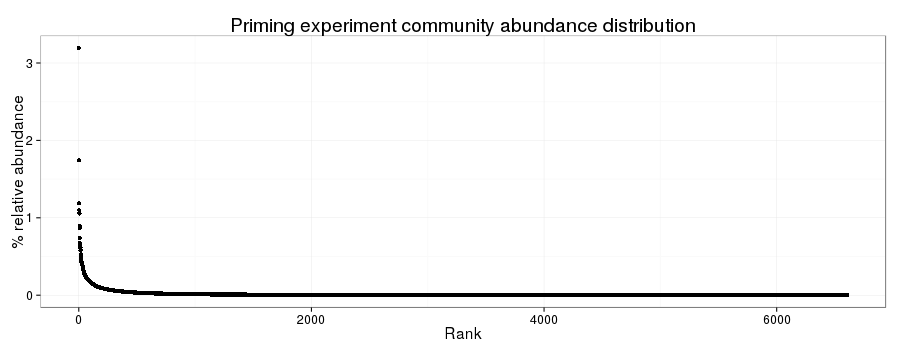

In [32]:
%%R -w 900 -h 350

ggplot(comm, aes(rank, rel_abund_perc)) +
    geom_point() +
    labs(x='Rank', y='% relative abundance', title='Priming experiment community abundance distribution') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Simulating fragments

## Making a genome index file to map genome fasta files to OTUs

* Will be used for community simulation
* Just OTUs with association to genomes

In [33]:
%%R -i taxonMapFile -i genomeFilterFile 

taxonMap = read.delim(taxonMapFile, sep='\t') %>%
    select(target_genome, OTU) %>%
    distinct()
taxonMap %>% nrow %>% print
taxonMap %>% head(n=3) %>% print

breaker = '----------------\n'
cat(breaker)

genomeFilter = read.delim(genomeFilterFile, sep='\t', header=F) 
genomeFilter %>% nrow %>% print
genomeFilter %>% head(n=3) %>% print

cat(breaker)

comm = read.delim(commFile, sep='\t') 
comm %>% nrow %>% print
comm %>% head(n=3) %>% print

[1] 236
                               target_genome      OTU
1 CP001738_Thermomonospora_curvata_DSM_43183 OTU.8540
2 CP001738_Thermomonospora_curvata_DSM_43183 OTU.9267
3 CP001738_Thermomonospora_curvata_DSM_43183 OTU.1457
----------------
[1] 187
                                                         V1
1                  CP003093_Pseudoxanthomonas_spadix_BD_a59
2                  CP000511_Mycobacterium_vanbaalenii_PYR_1
3 CP003344_Desulfitobacterium_dichloroeliminans_LMG_P_21439
                                                                                                            V2
1                  /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Pseudoxanthomonas_spadix_BD-a59.fasta
2                  /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Mycobacterium_vanbaalenii_PYR-1.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Desulfitobacterium_dichloroeliminans_LMG_P-21439.fasta
----------------
[1] 6606
  library taxon_name rel_abund_perc rank


In [34]:
%%R
taxonMap$OTU %>% table %>% sort(decreasing=T) %>% head

.
    OTU.1    OTU.10   OTU.101   OTU.102 OTU.10237  OTU.1035 
        1         1         1         1         1         1 


In [35]:
%%R

tbl.j = inner_join(taxonMap, genomeFilter, c('target_genome' = 'V1')) %>%
     rename('fasta_file' = V2) %>%
     select(OTU, fasta_file, target_genome)

tbl.j %>% head(n=3)

       OTU
1 OTU.8540
2 OTU.9267
3 OTU.1457
                                                                                     fasta_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
                               target_genome
1 CP001738_Thermomonospora_curvata_DSM_43183
2 CP001738_Thermomonospora_curvata_DSM_43183
3 CP001738_Thermomonospora_curvata_DSM_43183


In [36]:
%%R
tbl.j$OTU %>% table %>% sort(decreasing=T) %>% head

.
    OTU.1    OTU.10   OTU.101   OTU.102 OTU.10237  OTU.1035 
        1         1         1         1         1         1 


In [37]:
%%R
tbl.j2 = inner_join(tbl.j, comm, c('OTU' = 'taxon_name')) 

n.target.genomes = tbl.j2$OTU %>% unique %>% length
cat('Number of target OTUs: ', n.target.genomes, '\n')
cat('--------', '\n')
tbl.j2 %>% head(n=3)

Number of target OTUs:  198 
-------- 
       OTU
1 OTU.8540
2 OTU.9267
3 OTU.1457
                                                                                     fasta_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
                               target_genome library rel_abund_perc rank
1 CP001738_Thermomonospora_curvata_DSM_43183       1    0.002582583 4561
2 CP001738_Thermomonospora_curvata_DSM_43183       1    0.005045402 2191
3 CP001738_Thermomonospora_curvata_DSM_43183       1    0.011258918 1106


In [38]:
%%R -i workDir

outFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')
write.table(tbl.j2, outFile, sep='\t', quote=F, row.names=F, col.names=F)

## Plotting community abundance distribution of target genomes

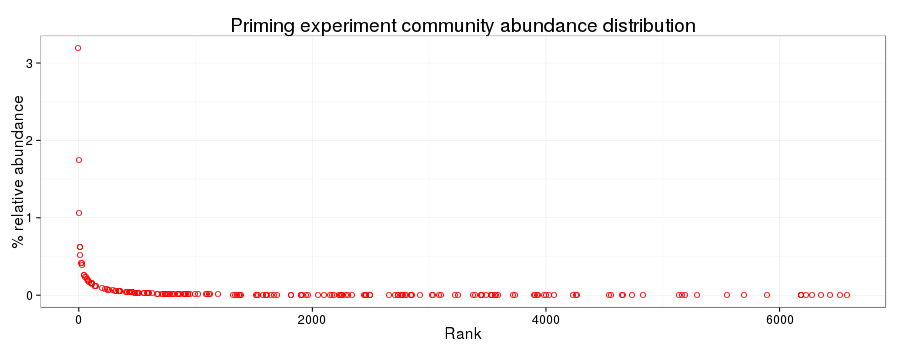

In [39]:
%%R -w 900 -h 350

ggplot(tbl.j2, aes(rank, rel_abund_perc)) +
    geom_point(size=3, shape='O', color='red') +
    labs(x='Rank', y='% relative abundance', title='Priming experiment community abundance distribution') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Simulating fragments of genomes that match priming_exp bulk OTUs

In [43]:
!cd $workDir; \
    SIPSim fragments \
    target_genome_index.txt \
    --fp $genomeDir \
    --fr $primerFile \
    --fld skewed-normal,5000,2000,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    --tbl \
    2> ampFrags.log \
    > ampFrags.txt

## Plotting fragment length distribution

In [44]:
%%R -i workDir

inFile = paste(c(workDir, 'ampFrags.txt'), collapse='/')

tbl = read.delim(inFile, sep='\t')
tbl %>% head(n=3)

  taxon_name                                 scaffoldID fragStart fragLength
1   OTU.8540 CP001738_Thermomonospora_curvata_DSM_43183   5586544       3830
2   OTU.8540 CP001738_Thermomonospora_curvata_DSM_43183    266123       3970
3   OTU.8540 CP001738_Thermomonospora_curvata_DSM_43183   2985740       2451
    fragGC
1 68.19843
2 67.83375
3 72.46022


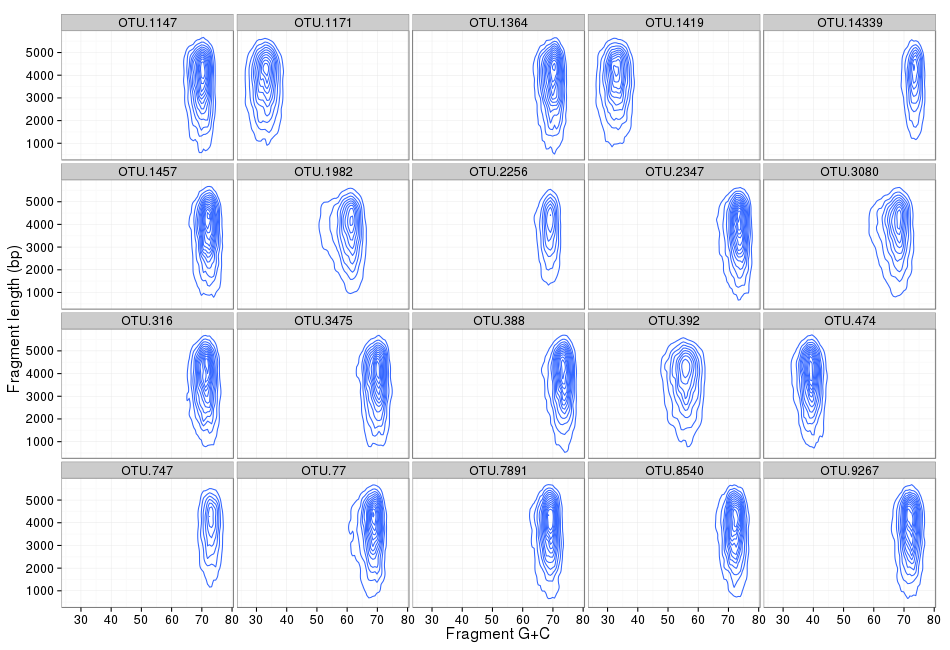

In [50]:
%%R -w 950 -h 650

some.taxa = tbl$taxon_name %>% unique %>% head(n=20)

tbl.f = tbl %>% 
    filter(taxon_name %in% some.taxa)

ggplot(tbl.f, aes(fragGC, fragLength)) +
    stat_density2d() +
    labs(x='Fragment G+C', y='Fragment length (bp)') +
    facet_wrap(~ taxon_name, ncol=5) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y=element_text(vjust=1)
        )

In [46]:
# re-running simulation with pickled file

!cd $workDir; \
    SIPSim fragments \
    target_genome_index.txt \
    --fp $genomeDir \
    --fr $primerFile \
    --fld skewed-normal,5000,2000,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    2> ampFrags.log \
    > ampFrags.pkl

# Simulating fragments of total dataset with a greater diffusion

In [48]:
!cd $workDir; \
    SIPSim fragments \
    $genomeAllIndex \
    --fp $genomeAllDir \
    --fr $primerFile \
    --fld skewed-normal,5000,2000,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    2> ampFragsAll.log \
    > ampFragsAll.pkl

In [49]:
ampFragsAllFile = os.path.join(workDir, 'ampFragsAll.pkl')

## Appending fragments from randomly selected genomes of total dataset (n=1210)

* This is to obtain the richness of the bulk soil community
* Random OTUs will be named after non-target OTUs in comm file

### Making list of non-target OTUs

In [51]:
%%R -i workDir
# loading files

## target genome index (just OTUs with associated genome)
inFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')
tbl.target = read.delim(inFile, sep='\t', header=F)
colnames(tbl.target) = c('OTUId', 'fasta_file', 'genome_name')

## comm file of total community OTUs 
commFile = paste(c(workDir, 'comm.txt'), collapse='/')
tbl.comm = read.delim(commFile, sep='\t')

In [52]:
%%R
# just OTUs w/out an associated genome
tbl.j = anti_join(tbl.comm, tbl.target, c('taxon_name' = 'OTUId'))
n.nontarget.genomes = tbl.j$taxon_name %>% length
cat('Number of non-target genomes: ', n.nontarget.genomes, '\n')
cat('---------\n')
tbl.j %>% head(n=5)

Number of non-target genomes:  6408 
---------
  library taxon_name rel_abund_perc rank
1       1   OTU.9280   0.0008491831 6606
2       1   OTU.8991   0.0008491831 6605
3       1   OTU.8467   0.0008491831 6604
4       1   OTU.7687   0.0008491831 6603
5       1   OTU.7201   0.0008491831 6602


In [53]:
%%R -i comm_richness
# checking assumptions
cat('Target + nonTarget richness = total community richness?: ',
    n.target.genomes + n.nontarget.genomes == comm_richness, '\n')

Target + nonTarget richness = total community richness?:  TRUE 


In [54]:
%%R -i workDir
# writing out non-target OTU file
outFile = paste(c(workDir, 'comm_nonTarget.txt'), collapse='/')
write.table(tbl.j, outFile, sep='\t', quote=F, row.names=F)

### Randomly selecting amplicon fragment length-GC KDEs from total genome pool

In [55]:
# List of non-target OTUs
inFile = os.path.join(workDir, 'comm_nonTarget.txt')
nonTarget = pd.read_csv(inFile, sep='\t')['taxon_name'].tolist()

print 'Number of non-target OTUs: {}'.format(len(nonTarget))
nonTarget[:4]

Number of non-target OTUs: 6408


['OTU.9280', 'OTU.8991', 'OTU.8467', 'OTU.7687']

In [56]:
# loading amplicon fragments from full genome KDE dataset
inFile = os.path.join(workDir, 'ampFrags.pkl')
ampFrag_target = []
with open(inFile, 'rb') as iFH:
    ampFrag_target = pickle.load(iFH)
print 'Target OTU richness: {}'.format(len(ampFrag_target))

Target OTU richness: 198


In [57]:
# loading amplicon fragments from full genome KDE dataset
ampFrag_all = []
with open(allAmpFrags, 'rb') as iFH:
    ampFrag_all = pickle.load(iFH)
print 'Count of frag-GC KDEs for all genomes: {}'.format(len(ampFrag_all))    

Count of frag-GC KDEs for all genomes: 1210


In [58]:
# random selection from list
#target_richness = len(ampFrag_target)

target_richness = len(ampFrag_target)
richness_needed = comm_richness - target_richness
print 'Number of random taxa needed to reach richness: {}'.format(richness_needed)

if richness_needed > 0:
    index = range(target_richness)
    index = np.random.choice(index, richness_needed)
    
    ampFrag_rand = []
    for i in index:
        sys.stderr.write('{},'.format(i))
        ampFrag_rand.append(copy.deepcopy(ampFrag_all[i]))
else:
    ampFrag_rand = []

127,196,70,29,4,84,121,40,24,111,131,3,185,178,103,19,25,112,179,74,47,28,196,114,112,55,98,108,46,85,155,79,182,102,195,0,22,39,146,72,160,5,40,30,51,71,115,11,137,38,188,124,158,114,55,164,73,121,145,134,148,193,162,128,40,168,38,177,32,10,59,134,19,74,35,118,114,123,179,127,2,32,64,108,2,81,132,99,134,46,111,190,36,149,157,81,161,93,145,53,135,153,195,69,160,12,109,127,164,145,158,7,139,31,56,137,177,28,28,161,25,160,174,90,98,1,187,189,43,141,46,165,3,89,183,46,58,39,68,84,187,61,153,148,186,134,163,102,31,16,8,81,71,86,18,13,128,133,29,45,61,182,77,22,54,116,22,77,102,83,105,56,189,118,177,172,167,191,9,115,72,43,122,113,95,13,117,71,29,187,1,139,30,126,30,138,110,174,31,37,82,29,197,138,84,192,13,135,85,83,164,172,102,150,70,61,179,186,105,153,53,76,52,24,100,66,161,192,132,63,88,166,149,182,106,171,189,175,94,116,20,78,197,141,115,121,130,191,96,23,117,66,120,178,42,85,33,143,140,157,52,62,147,74,183,52,90,196,84,75,168,52,136,26,167,34,10,51,42,33,181,172,64,108,19,155,137,18,1

Number of random taxa needed to reach richness: 6408


In [59]:
# renaming randomly selected KDEs by non-target OTU-ID
for i in range(len(ampFrag_rand)):
    ampFrag_rand[i][0] = nonTarget[i]

In [ ]:
# appending random taxa to target taxa and writing
outFile = os.path.join(workDir, 'ampFrags_wRand.pkl')

with open(outFile, 'wb') as oFH:
    x = ampFrag_target + ampFrag_rand
    print 'Number of taxa in output: {}'.format(len(x))
    pickle.dump(x, oFH)

Number of taxa in output: 6606


# Converting fragments to kde object

In [ ]:
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrags_wRand.pkl \
    > ampFrags_wRand_kde.pkl

# Adding diffusion

In [ ]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_wRand_kde.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif.pkl    

# Making an incorp config file

In [ ]:
!cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 0 \
    --percIncorpUnif 100 \
    > PT0_PI100.config

# Adding isotope incorporation to BD distribution

In [ ]:
!cd $workDir; \
    SIPSim isotope_incorp \
    ampFrags_wRand_kde_dif.pkl \
    PT0_PI100.config \
    --comm comm.txt \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp.pkl

# Calculating BD shift from isotope incorporation

In [ ]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrags_wRand_kde_dif.pkl \
    ampFrags_wRand_kde_dif_incorp.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp_BD-shift.txt

# Simulating gradient fractions

In [ ]:
!cd $workDir; \
    SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt

# Simulating an OTU table

In [ ]:
!cd $workDir; \
    SIPSim OTU_table \
    ampFrags_wRand_kde_dif_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e9 \
    --np $nprocs \
    > OTU_abs1e9.txt

## Plotting taxon abundances

In [ ]:
%%R -i workDir
setwd(workDir)

# loading file
tbl = read.delim('OTU_abs1e9.txt', sep='\t')

In [ ]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

In [ ]:
%%R -w 800 -h 300
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count))

## plot
p = ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

In [ ]:
%%R -w 800 -h 300
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

In [ ]:
%%R -w 800 -h 250
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

In [ ]:
%%R -w 800 -h 250

p + geom_area(stat='identity', position='fill')

# Subsampling from the OTU table

In [ ]:
dist,loc,scale = seq_per_fraction

!cd $workDir; \
    SIPSim OTU_subsample \
    --dist $dist \
    --dist_params mean:$loc,sigma:$scale \
    --walk 2 \
    --min_size 10000 \
    --max_size 200000 \
    OTU_abs1e9.txt \
    > OTU_abs1e9_sub.txt  

### Testing/Plotting seq count distribution of subsampled fraction samples

In [ ]:
%%R -h 300 -i workDir
setwd(workDir)

tbl = read.csv('OTU_abs1e9_sub.txt', sep='\t') 

tbl.s = tbl %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(tbl.s, aes(total_count)) +
    geom_density(fill='blue')

In [ ]:
%%R -h 300 -w 600
setwd(workDir)

tbl.s = tbl %>%
    group_by(fraction, BD_min, BD_mid, BD_max) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Getting list of target taxa

In [ ]:
%%R -i workDir

inFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')

tbl.target = read.delim(inFile, sep='\t', header=F)
colnames(tbl.target) = c('OTUId', 'genome_file', 'genome_ID', 'X', 'Y', 'Z')
tbl.target = tbl.target %>% distinct(OTUId)


cat('Number of target OTUs: ', tbl.target$OTUId %>% unique %>% length, '\n')
cat('----------\n')
tbl.target %>% head(n=3)

## Plotting abundance distributions

In [ ]:
%%R -w 800 -h 250
# plotting relative abundances

tbl = tbl %>% 
    group_by(fraction) %>%
    mutate(rel_abund = count / sum(count))


## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

In [ ]:
%%R -w 800 -h 250

p = ggplot(tbl, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity')

### Abundance distribution of just target taxa

In [ ]:
%%R

targets = tbl.target$OTUId %>% as.vector %>% unique 

tbl.f = tbl %>%
    filter(taxon %in% targets)

tbl.f %>% head

In [ ]:
%%R -w 800 -h 250
# plotting absolute abundances

## plot
p = ggplot(tbl.f, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

In [ ]:
%%R -w 800 -h 250
# plotting relative abundances

p = ggplot(tbl.f, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity')

# Plotting 'true' taxon abundance distribution (from priming exp dataset)

In [ ]:
%%R -i metaDataFile
# loading priming_exp metadata file

meta = read.delim(metaDataFile, sep='\t')
meta %>% head(n=4)

In [ ]:
%%R -i otuTableFile
# loading priming_exp OTU table 

tbl.otu.true = read.delim(otuTableFile, sep='\t') %>%
    select(OTUId, starts_with('X12C.700.14')) 
tbl.otu.true %>% head(n=3)

In [ ]:
%%R
# editing table
tbl.otu.true.w = tbl.otu.true %>%
    gather('sample', 'count', 2:ncol(tbl.otu.true)) %>%
    mutate(sample = gsub('^X', '', sample)) %>%
    group_by(sample) %>%
    mutate(rel_abund = count / sum(count)) %>%
    ungroup() %>%
    filter(count > 0)
tbl.otu.true.w %>% head(n=5)

In [ ]:
%%R
tbl.true.j = inner_join(tbl.otu.true.w, meta, c('sample' = 'Sample'))
tbl.true.j %>% as.data.frame %>% head(n=3)

In [ ]:
%%R -w 800 -h 300  -i workDir
# plotting number of taxa at each BD

tbl = read.csv('OTU_abs1e9_sub.txt', sep='\t') 

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_area(stat='identity', alpha=0.5) +
    geom_point() +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

In [ ]:
%%R -w 700 -h 350

tbl.true.j.s = tbl.true.j %>%
    filter(count > 0) %>%
    group_by(sample, Density) %>%
    summarize(n_taxa = sum(count > 0))

ggplot(tbl.true.j.s, aes(Density, n_taxa)) +
    geom_area(stat='identity', alpha=0.5) +
    geom_point() +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

### Plotting total counts for each sample

In [ ]:
%%R -h 300 -w 600
tbl.true.j.s = tbl.true.j %>%
    group_by(sample, Density) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.true.j.s, aes(Density, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

### Plotting abundance distribution of target OTUs

In [ ]:
%%R
tbl.true.j.f = tbl.true.j %>%
    filter(OTUId %in% targets) %>%
    arrange(OTUId, Density) %>%
    group_by(sample)
tbl.true.j.f %>% head(n=3) %>% as.data.frame

In [ ]:
%%R -w 800 -h 250
# plotting relative abundances

## plot
ggplot(tbl.true.j.f, aes(Density, rel_abund, fill=OTUId)) +
    geom_area(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

## Combining true and simulated OTU tables for target taxa

In [ ]:
%%R
tbl.f.e = tbl.f %>%
    mutate(library = 'simulation') %>%
    rename('density' = BD_mid) %>%
    select(-BD_min, -BD_max)

tbl.true.e = tbl.true.j.f %>% 
    select('taxon' = OTUId,
           'fraction' = sample,
           'density' = Density,
           count, rel_abund) %>%
    mutate(library = 'true') 
           
           
tbl.sim.true = rbind(tbl.f.e, tbl.true.e) %>% as.data.frame
tbl.f.e = data.frame()
tbl.true.e = data.frame()

tbl.sim.true %>% head(n=3)

In [ ]:
%%R
# check
cat('Number of target taxa: ', tbl.sim.true$taxon %>% unique %>% length, '\n')

## Abundance distributions of each target taxon

In [ ]:
%%R -w 900 -h 3500

tbl.sim.true.f = tbl.sim.true %>%
    ungroup() %>%
    filter(density >= 1.6772) %>%
    filter(density <= 1.7603) %>%
    group_by(taxon) %>%
    mutate(mean_rel_abund = mean(rel_abund))  %>%
    ungroup()

tbl.sim.true.f$taxon = reorder(tbl.sim.true.f$taxon, -tbl.sim.true.f$mean_rel_abund)

ggplot(tbl.sim.true.f, aes(density, rel_abund, color=library)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    facet_wrap(~ taxon, ncol=4, scales='free_y')